<h1>Crackup</h1>
<p><i> ICESAT-2 hackweek, June 17-21, 2019</i></p>


<p>Our group goal was to pull out ATL03 and ATL06 segments from two areas where we saw crevasses, and compare small scale features in the two datasets


<h2>Location/time </h2>
After a preliminary look at the data, we pulled out a granules at two locations using KML files and a short time    window

<ul>
    <li>georgeVI_meltpond-polygon.kml : Feb5 - Feb7, 2019
    <li>edgeworth_simple-polygon.kml : Oct 14 - Oct 16, 2018
 </ul>


We tried a more complex polygon, and this program had trouble finding the data.  So we had to go with a simple polygon.

<h2>Downloading ATL03 and ATL06 data</h2>
The code we used to get the ATL03 and ATLO6 data for a specific time period and within a KML polygon is shown below.  

<b>In the code below, set:
<ul> 
    <li>short_name: ATL03 or ATL06 
    <li>temporal range
    <li>kml_filepath
    <li> output file directory.  Default is ./Output_files
</ul>
</b>   

<h3> Libaries for download script</h3>

In [13]:

#import libraries
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import h5py
import re
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth


<b>In the code below, set:
<ul> 
    <li>short_name: ATL03 or ATL06 
    <li>temporal range
    <li>kml_filepath
    <li> output file directory 
    <li> Earthdata login credentials
</ul>
</b>   

In [14]:

# Input data set ID (e.g. ATL06) of interest here, also known as "short name".

short_name = 'ATL03'

# Input temporal range 

# Input start date in yyyy-MM-dd format
start_date = '2019-02-05'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-02-07'
# Input end time in HH:mm:ss format
end_time = '23:59:59'


kml_filepath = str('/home/jovyan/crackup/shapefiles/georgeVI_meltpond-polygon.kml')


# set directory for subsetted files
path = str(os.getcwd() + '/ATL_Output')

# Earthdata Login credentials

# Enter your Earthdata Login user name
uid = 'slhoward'
# Enter your email address associated with your Earthdata Login account
email = 'showard@esr.org'
pswd = getpass.getpass('Earthdata Login password: ')

# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)


Earthdata Login password:  ·········


49A32BD7-1D3E-8AA6-16FD-D10519F1752F


In [15]:
# Get data:

# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
#pprint.pprint(results)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
print(latest_version)

print(kml_filepath)

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

# Use geopandas to read in polygon file
# Note: a shapefile or geojson, or almost any other vector-based spatial data format could be substituted here.


#Return a GeoDataFrame object
gdf = gpd.read_file(kml_filepath)

#Integer position based indexing of GeoDataFrame object to get it into a shapeply geometry object.
poly = gdf.iloc[0].geometry

# Simplify polygon. The larger the tolerance value, the more simplified the polygon.
poly = poly.simplify(0.05, preserve_topology=False)

# Orient counter-clockwise
poly = orient(poly, sign=1.0)

#print(poly)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# aoi value used for CMR params below
aoi = '3'


#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

#print('CMR search parameters: ', params)

# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)

granule_sizes = [float(granule['granule_size']) for granule in granules]

# Average size of granules in MB
mean(granule_sizes)

# Total volume in MB
sum(granule_sizes)

# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

print(capability_url)

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

print(subagent)
if len(subagent) < 1 :
    agent = 'NO'
    
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time
print(timevar) 




#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

# Determine how many individual orders we will request based on the number of granules requested

print(page_num)


subset_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'time': timevar, 
    'polygon': polygon, 
#    'Coverage': coverage, 
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }
#print(subset_params)


if not os.path.exists(path):
    os.mkdir(path)
    
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    subset_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

    shape_post = {'shapefile': open(kml_filepath, 'rb')}
    request = session.post(base_url, params=subset_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
#     request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
#    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
#    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')

#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))
        
#List files
sorted(os.listdir(path))


001
/home/jovyan/crackup/shapefiles/georgeVI_meltpond-polygon.kml
2019-02-05T00:00:00Z,2019-02-07T23:59:59Z
https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.001.xml
[{'id': 'ICESAT2', 'spatialSubsetting': 'true', 'spatialSubsettingShapefile': 'true', 'temporalSubsetting': 'true', 'type': 'both', 'maxGransSyncRequest': '100', 'maxGransAsyncRequest': '2000'}]
2019-02-05T00:00:00,2019-02-07T23:59:59
1
Order:  1
Request HTTP response:  201
order ID:  5000000320456
status URL:  https://n5eil02u.ecs.nsidc.org/egi/request/5000000320456
HTTP response from order response URL:  201
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry request status is:  processing
Status is not complete. Trying again.
Retry 

['processed_ATL03_20190206021109_06050210_001_01.h5',
 'processed_ATL03_20190206145852_06130212_001_01.h5']

<h2>Visualization of data

<h3> Plotting routine to make simple plots showing location of ATL03 granules</h3>
    * Select file, file path, and beam

In [17]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
#import seaborn as sns
import pandas as pd
import h5py  
import s3fs
import readers as rd
import utils as ut
from glob import glob
# Use seaborn for nicer looking inline plots
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")



In [18]:
#selected files to plot
ATL03file='processed_ATL03_20190206145852_06130212_001_01.h5'
localFilePath='/home/jovyan/crackup/Outputs_selected/georgeVI/'+ATL03file

ATL03file2='processed_ATL03_20181015194309_02620112_001_01.h5'
localFilePath2='/home/jovyan/crackup/Outputs_selected/edgeworth/'+ATL03file2

#select beam
beamStr='gt1r'

In [19]:
def getATL03data(fileT, numpyout=False, beam='gt1r'):
    """ Pandas/numpy ATL03 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL03 I think are of most interest to sea ice users, but by no
    means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL03 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you
    might want
    
    Args:
        fileT (str): File path of the ATL03 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        
    returns:
        either: select numpy arrays or a pandas dataframe

    """
    
    # Open the file
    try:
        ATL03 = h5py.File(fileT, 'r')
    except:
        'Not a valid file'
        
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    #  Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute the full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    # This function seems pretty convoluted but it works for now..
    # Sure there is a simpler functionw e can use here instead.
    temp = ut.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]
    #delta_time_granule=delta_time
    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    
    
    # Primary variables of interest
    
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    #print(heights.shape)
    
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,3] 
    
    # Add photon rate, background rate etc to the reader here if we want
    
    ATL03.close()
    
    
    
    dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats,
                       'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule})
    
    # Add the datetime string
    dFtimepd=pd.to_datetime(dFtime)
    dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
    
    # Filter out high elevation values 
    #dF = dF[(dF['signal_confidence']>2)]
    # Reset row indexing
    #dF=dF.reset_index(drop=True)
    return dF
    
    # Or return as numpy arrays 
    # return along_track_distance, heights

    

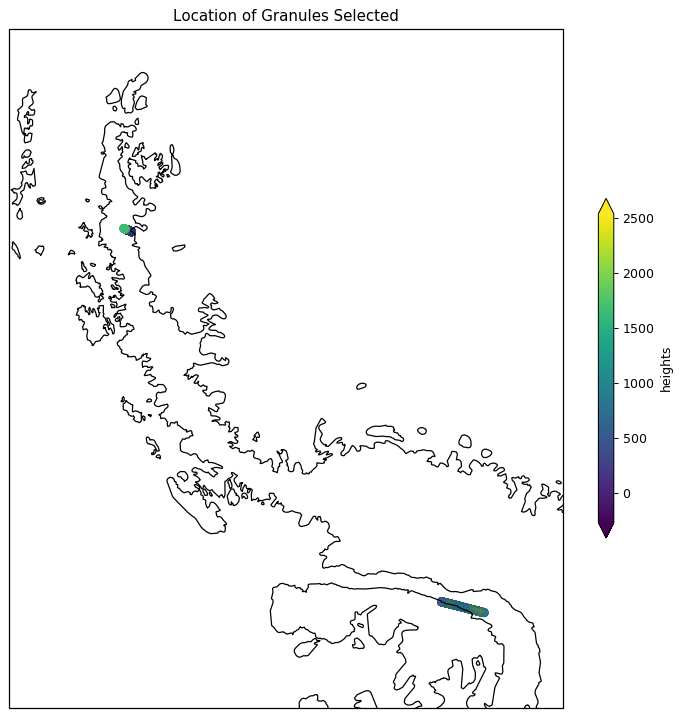

In [20]:
#read both files
dF03= getATL03data(localFilePath, beamStr)    # georgeVI
dF03_e= getATL03data(localFilePath2, beamStr)  #edgeworth

#plot

coast=shapereader.natural_earth(resolution='10m',category='physical',name='coastline')

coastlines=shapereader.Reader(coast).geometries()
# Generate a shorted version for mapping purposes
dF03short=dF03.iloc[::500, :]
dF03short.head(5)

dF03short_e=dF03_e.iloc[::500, :]
dF03short_e.head(5)
var='heights'

plt.figure(figsize=(10,10), dpi= 90)
# Make a new "NorthPolarStereo" projection instance
ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
plt.scatter(dF03short['lons'], dF03short['lats'],c=dF03short[var], cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(dF03short_e['lons'], dF03short_e['lats'],c=dF03short_e[var], cmap='viridis', transform=ccrs.PlateCarree())
#ax.coastlines()
ax.add_geometries(coastlines,ccrs.Geodetic(),edgecolor='k',facecolor='none')
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')
plt.title('Location of Granules Selected')
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-75, -50, -70, -65], ccrs.PlateCarree())